In [1]:
from __future__ import division
from astropy.io import fits
import os
import glob
import copy
import numpy as np
from astropy.table import Table, Column
import astropy.wcs as wcs
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.utils.data import get_pkg_data_filename
from astropy.io import ascii
from scipy.optimize import curve_fit
import sys


import sep
import matplotlib.pyplot as plt
import copy

sep.set_extract_pixstack(30000000)
from IPython.display import clear_output


from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [2]:
# define path
path = 'Documents/136P1'

In [3]:
cd

/Users/runquanguan


In [4]:
os.chdir(path)
filename = glob.glob('*')

In [5]:
def get_bias(folder):
    Bias = []
    ARRAY = []
    # pick out bias frame
    for file in folder:
        hdul = fits.open(file)
        TYPE = hdul[0].header['IMAGETYP']
        if TYPE == 'Bias Frame':
            Bias.append(file)
            
    # extract data array from data 
    for file in Bias:
        hdul_b = fits.open(file)
        array = hdul_b[0].data
        # form arrays as a list
        ARRAY.append(array)
    # turn list into array again to sum up
    ARRAY = np.array(ARRAY)
    # sum up
    SUM = ARRAY.sum(axis=0)
    # average out
    AVG = SUM/len(ARRAY)
    # return result
    return AVG
   

In [6]:
np.average(get_bias(filename))

106.91478162245288

In [7]:
def minus_bias(folder):
    
    # build new lists
    science_frame = []
    dark_frame = []
    
    # define bias frame
    bias_frame = get_bias(folder)
    
    # clasify science frames and dark frames
    for file in folder:
        hdul = fits.open(file)
        
    # declare variables
        EXPTIME = hdul[0].header['EXPTIME']
        TYPE = hdul[0].header['IMAGETYP']
        DATA = hdul[0].data
        
    # classification
        if TYPE == 'Dark Frame':
            # remove bias for Dark frame
            DATA = DATA - bias_frame
            hdul[0].data = DATA
            
            new_file = file[0:20]+"d"+file[20:29]
            hdul.writeto(new_file,overwrite=True)
            dark_frame.append(new_file)
            
        elif TYPE == 'Light Frame':
            # remove bias for Science frame
            DATA = DATA - bias_frame
            hdul[0].data = DATA
            
            new_file = file[0:20]+"l"+file[20:29]
            hdul.writeto(new_file,overwrite=True)            
            science_frame.append(new_file)
            
        else:
            pass

        
    return science_frame, dark_frame


In [8]:
def flat_fielding(science_frame, dark_frame):
    final_frame = []
    
    # matching exposure time    
    for file_s in science_frame:
        
        hdul_s = fits.open(file_s)
        EXPTIME_s = hdul_s[0].header['EXPTIME']
        
        # for each science: match a dark by EXPST
        for file_d in dark_frame:
            
            hdul_d = fits.open(file_d)
            EXPTIME_d = hdul_d[0].header['EXPTIME']
            
            if EXPTIME_s == EXPTIME_d:
                final = hdul_s[0].data - hdul_d[0].data
                hdul_s[0].data = final
                
                new_file = file_s[0:20]+"f"+file_s[20:29]
                hdul_s.writeto(new_file,overwrite=True) 
                final_frame.append(new_file)
            else:
                pass

    return final_frame


In [9]:
science_frame, dark_frame = minus_bias(filename)

final_flame = flat_fielding(science_frame, dark_frame)


In [10]:
JBE = EarthLocation(lat=37.005*u.deg, lon=-122.0631*u.deg, height=249*u.m)
utcoffset = -8*u.hour  # Eastern Daylight Time

time_set = []
exptime = []
ppixel = []
ppixel_sec = []


for name in final_flame:
    hudl = fits.open(name)
    
    hh = int(hudl[0].header['DATE-OBS'][11:][:2])
    mm = int(hudl[0].header['DATE-OBS'][11:][3:5])
    ss = int(hudl[0].header['DATE-OBS'][11:][6:8])
    time_set.append(hh + mm/60 + ss/3600) 
    
    exptime.append(hudl[0].header['EXPTIME'])
    ppixel.append(np.average(hudl[0].data))
    ppixel_sec.append(np.average(hudl[0].data)/hudl[0].header['EXPTIME'])
    
    

   
    

In [11]:
timeset = Column(name='time', data=np.array(time_set), dtype=np.float64)
exptime = Column(name='exptime', data=np.array(exptime))
filename = Column(name='filename', data=final_flame)
ppixel = Column(name='ppixel', data=ppixel)
ppixel_sec = Column(name='ppixel_sec', data=ppixel_sec)

catalog = Table([filename, timeset ,exptime, ppixel,ppixel_sec])

In [12]:
catalog.sort('filename')
catalog

filename,time,exptime,ppixel,ppixel_sec
str26,float64,float64,float64,float64
ASTR136_COS.00000033fl.FIT,12.171388888888888,30.0,8.940576701268743,0.29801922337562475
ASTR136_COS.00000034fl.FIT,12.1975,60.0,20.53022427271562,0.3421704045452604
ASTR136_COS.00000035fl.FIT,12.22861111111111,60.0,15.876511598103294,0.2646085266350549
ASTR136_COS.00000036fl.FIT,12.246388888888887,60.0,13.875383826733307,0.2312563971122218
ASTR136_COS.00000037fl.FIT,12.264444444444445,60.0,18.729926951172626,0.3121654491862104
ASTR136_COS.00000038fl.FIT,12.297222222222222,50.0,15.729696270665128,0.31459392541330256
ASTR136_COS.00000039fl.FIT,12.312222222222223,50.0,14.967768806869152,0.29935537613738306
ASTR136_COS.00000040fl.FIT,12.3275,50.0,13.465044213763937,0.26930088427527876
ASTR136_COS.00000041fl.FIT,12.346666666666668,50.0,16.224385492759197,0.32448770985518394


In [13]:
x = catalog['time']
y = catalog['ppixel_sec']

fit = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
print(fit)

xx = np.linspace(12.19,12.54)
yy = np.exp(fit[1]) * np.exp(fit[0] * xx)


[-0.94287727 10.33594743]


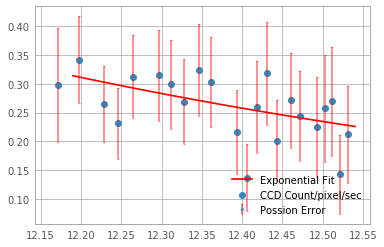

In [14]:
# plotting

plt.scatter(catalog['time'],catalog['ppixel_sec'],label='CCD Count/pixel/sec')

plt.errorbar(catalog['time'],catalog['ppixel_sec'], yerr=np.sqrt(catalog['ppixel'])/catalog['exptime'],
             fmt='.',ecolor = 'r',alpha = 0.5,capsize=1,label='Possion Error')

plt.plot(xx,yy,c='r',label='Exponential Fit')
plt.legend(loc=4, frameon=False)

## Test space

In [20]:
hudl = fits.open('ASTR136_COS.00000034.FIT')

hudl[0].header['EXPTIME']
hudl[0].data



60.0

In [27]:
hudla = fits.open('ASTR136_COS.00000055.DARK.FIT')

count = hudl[0].data-hudla[0].data
#np.average(count)
count[1]

array([   20,    14,    24,    32,     1,    26,    15,    34,    21,
          35,    24,    22,    28,    27,    32,    19,    19,    22,
          36,     8,    22,    26,    28,    14, 65534,    11,    18,
          13,    30,    30,     8,     5,    19,    20,    26,    22,
          19,    24,     5,    25,    16,     0,    11,    17,    19,
          31,    29,    36,    19,    48,    22,    23,    26,    30,
          24,    35,    22,    20,    22,    25,     4,    11,     5,
          26,    11,     6,    24,    21,     5,    24,    21,    20,
          11,     5,    13,    19,    32,    22,    15,    21,    22,
          24,    15,    26,    21, 65535,    21,    26,    27,    19,
          12,    19,    13,     6,    14,     9,    30,    17,    28,
          20,     5,    24,     9,    16,    19,    21,    26,    17,
          16,    28,     9,    11,    21,    13,     3,    15,    22,
          25,    25,    28,    24,     7,    25,     1,    16,    20,
          40,    17,

In [18]:
    hdul = fits.open('ASTR136_COS.00000055.DARK.FIT')
    TYPE = hdul[0].header['IMAGETYP']
    DATA = hdul[0].data
    EXPTIME = hdul[0].header['EXPTIME']
    bias = get_bias(filename)
    # classification
    if TYPE == 'Dark Frame':
        DATA = DATA - bias
        hdul[0].data = DATA
        hdul.writeto('ASTR136_COS.00000055a.DARK.FIT',overwrite=True)
    else:
        pass  
    
fits.getdata('ASTR136_COS.00000055a.DARK.FIT')

/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])